<a href="https://colab.research.google.com/github/Mahdi-Miri/Signal_Proccesing/blob/main/Signal_Proccesing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Data Readig

In [1]:
!pip install obspy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.9 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.43
    Uninstalling SQLAlchemy-2.0.43:
      Successfully uninstalled SQLAlchemy-2.0.43
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.54 which is incompatible.
google-adk 1.14.1 requires sqlalchemy<3.0.0,>=2.0, but you have sqlalchemy 1.4.54 which is incompatible.


##Modelling

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D,
    GlobalAveragePooling2D, TimeDistributed, Dense, Permute, Reshape, Layer
)
from tensorflow.keras.models import Model
import numpy as np

In [3]:
# --- Custom Layer Definition with Functional Implementation ---
# This layer now has a functional implementation based on the
# Auto-Correlation mechanism using Fast Fourier Transform (FFT).
class CustomAutocorrelationLayer(Layer):
    """
    A custom layer that calculates the temporal auto-correlation of an input tensor.
    It operates on the last axis, which is assumed to be the time dimension.
    The calculation is performed efficiently in the frequency domain using FFT.
    """
    def __init__(self, **kwargs):
        super(CustomAutocorrelationLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # The input shape is expected to be (Batch, Height, Width, TimeSteps)
        # We need to compute auto-correlation along the TimeSteps axis (axis=-1).

        # Get the length of the time series
        sequence_length = tf.shape(inputs)[-1]

        # --- Step 1: Go to Frequency Domain using FFT ---
        # Perform Fast Fourier Transform. tf.signal.rfft is used for real-valued inputs.
        # The length of the FFT is padded to the next power of 2 for efficiency,
        # but for simplicity, we'll use the original length here.
        fft_result = tf.signal.rfft(inputs, fft_length=[sequence_length])

        # --- Step 2: Compute Power Spectral Density ---
        # This is where the correlation is calculated.
        # It's done by multiplying the FFT result by its complex conjugate.
        # This is equivalent to convolution in the time domain.
        power_spectral_density = fft_result * tf.math.conj(fft_result)

        # --- Step 3: Go back to Time Domain using Inverse FFT ---
        # Perform Inverse Real Fast Fourier Transform to get the auto-correlation series.
        autocorr_result = tf.signal.irfft(power_spectral_density, fft_length=[sequence_length])

        return autocorr_result

    def get_config(self):
        # Required for model saving and loading
        config = super(CustomAutocorrelationLayer, self).get_config()
        return config

# --- Full Architecture Definition ---
def build_spatio_temporal_model(input_shape=(60, 60, 100)):
    """
    Builds the complete Spatio-Temporal feature extraction model based on the diagram.

    Args:
        input_shape (tuple): The shape of the input data (Height, Width, TimeSteps).

    Returns:
        keras.Model: The compiled Keras model.
    """
    # Define the input layer for our spatio-temporal data
    inputs = Input(shape=input_shape)

    # --- Part 1: Temporal Transformation & Reshaping ---

    # Apply the functional autocorrelation layer to find temporal patterns.
    # This layer processes each spatial point's time series (60x60 series of length 100).
    # Output values now represent the strength of temporal correlations.
    temporal_features = CustomAutocorrelationLayer(name = 'mamad')(inputs)  # Shape: (None, 60, 60, 100)

    # Permute the dimensions to bring the time-steps to the front for the next stage.
    # (Height, Width, TimeSteps) -> (TimeSteps, Height, Width)
    permuted = Permute((3, 1, 2))(temporal_features)  # Shape: (None, 100, 60, 60)

    # Reshape to add a 'channels' dimension. Each time-step is now a 60x60x1 image,
    # ready to be processed by a 2D CNN.
    reshaped = Reshape((100, 60, 60, 1))(permuted)  # Shape: (None, 100, 60, 60, 1)

    # --- Part 2: Time-Distributed Spatial Feature Extraction ---

    # Define the CNN block that extracts spatial features from a single 60x60 frame.
    cnn_block = tf.keras.Sequential([
        # Finds low-level features like edges and gradients.
        Conv2D(32, kernel_size=(3, 3), padding='same'),
        BatchNormalization(),
        ReLU(),
        # Downsamples the feature map to make representations more robust.
        MaxPooling2D(pool_size=(2, 2)),

        # Finds higher-level features by combining low-level ones.
        Conv2D(64, kernel_size=(3, 3), padding='same'),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D(pool_size=(2, 2)),

        # Summarizes all spatial features in the frame into a single, fixed-size vector.
        GlobalAveragePooling2D()
    ], name='internal_cnn_block')

    # Apply the defined cnn_block to each of the 100 time-steps independently.
    # The output is a sequence of 100 feature vectors, one for each time-step.
    time_distributed_cnn = TimeDistributed(cnn_block)(reshaped)  # Shape: (None, 100, 64)

    # --- Part 3: Final Transformation ---

    # A Dense layer refines the features from the CNN, reducing each feature vector's size to 10.
    # It learns combinations of the spatial features.
    dense_features = Dense(10, activation='relu')(time_distributed_cnn)  # Shape: (None, 100, 10)

    # Final permutation to get the output shape of (Features, TimeSteps).
    # This format might be useful for downstream tasks that analyze each feature over time.
    final_output = Permute((2, 1))(dense_features)  # Shape: (None, 10, 100)

    # Create the final model by defining its inputs and outputs
    model = Model(inputs=inputs, outputs=final_output, name='SpatioTemporal_Feature_Extractor')

    return model

# --- Model Creation, Compilation, and Execution Example ---

if __name__ == '__main__':
    # Define the input shape as per the diagram
    INPUT_SHAPE = (60, 60, 100)

    # Build the model
    model = build_spatio_temporal_model(input_shape=INPUT_SHAPE)

    # Compile the model. A loss function and optimizer are needed for training.
    # For feature extraction, you might not train it, but compilation is a good practice.
    model.compile(optimizer='adam', loss='mse')

    # Print the model summary to verify the architecture and shapes
    print("--- Model Summary ---")
    model.summary()

    # --- Example of running the model with dummy data ---
    print("\n--- Running a test prediction ---")
    # Create a batch of 2 dummy "videos" with random data
    dummy_data = np.random.rand(2, *INPUT_SHAPE)

    # Get the model's prediction
    predictions = model.predict(dummy_data)

    # Print the shape of the output to confirm it matches the design
    print(f"Input data shape: {dummy_data.shape}")
    print(f"Final output shape: {predictions.shape}")


--- Model Summary ---


Model: "SpatioTemporal_Feature_Extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 60, 100)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mamad                           │ (None, None, None,     │             0 │
│ (CustomAutocorrelationLayer)    │ 100)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute (Permute)               │ (None, 100, None,      │             0 │
│                                 │ None)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 100, 60, 60, 1) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 100, 64)        │        19,200 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100, 10)        │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute_1 (Permute)             │ (None, 10, 100)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,850 (77.54 KB)

 Trainable params: 19,658 (76.79 KB)

 Non-trainable params: 192 (768.00 B)


--- Running a test prediction ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
Input data shape: (2, 60, 60, 100)
Final output shape: (2, 10, 100)


##testing

In [4]:
from obspy.clients.fdsn import Client
client = Client("IRIS")  # Initialize Client to download data from IRIS
import glob
from scipy.signal import iirnotch, filtfilt
import os
import numpy as np
import matplotlib.pyplot as plt
from obspy.core import UTCDateTime, read, Stream
from obspy.core.inventory.inventory import read_inventory

In [5]:
def date_maker(year, month, day,hour, minute, second):
    year = str(int(year))
    month = str(int(month))
    day = str(int(day))
    hour = str(int(hour))
    minute = str(int(minute))
    second = str(int(second))

    if len(month) == 1:
        month = '0' + month
    if len(day) == 1:
        day = '0' + day
    if len(hour) == 1:
        hour = '0' + hour
    if len(minute) == 1:
        minute = '0' + minute
    if len(second) == 1:
        second = '0' + second

    YMDHMS = year + "-" + month + "-" + day + "-" + hour + "-" + minute + "-" + second
    return YMDHMS

In [6]:
def plot_spectrum(data, sampling_rate, title):
    n = len(data)
    fft_data = np.fft.rfft(data)
    freqs = np.fft.rfftfreq(n, 1 / sampling_rate)
    plt.figure(figsize=(8, 4))
    plt.plot(freqs, np.abs(fft_data))
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

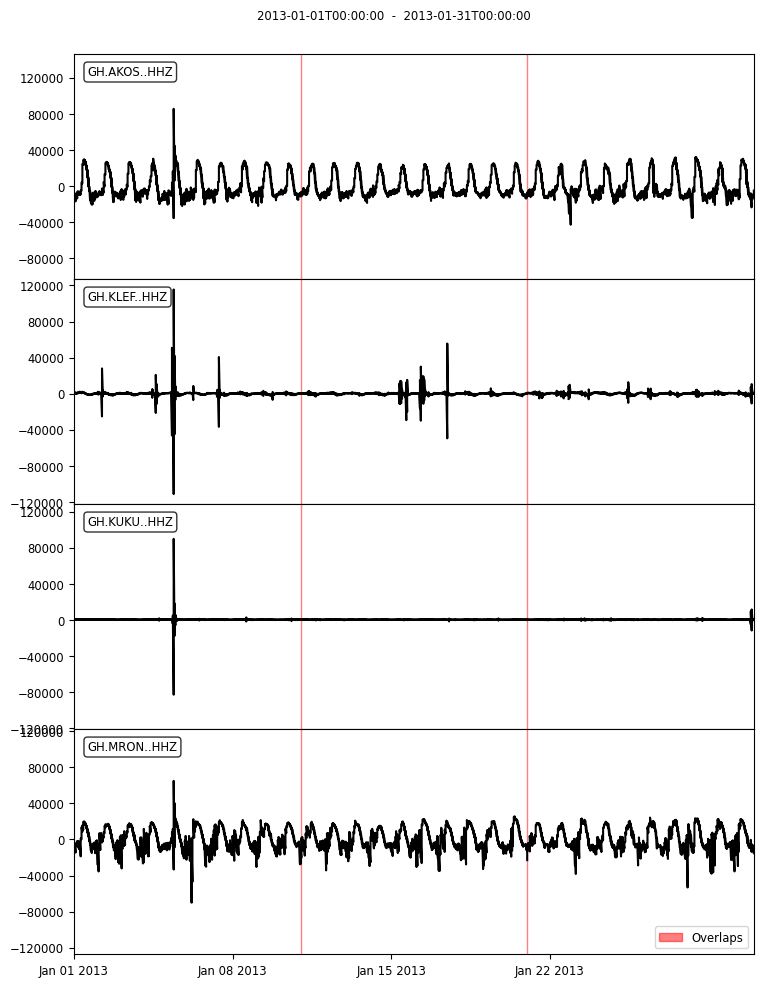

In [7]:
network = "GH"
# station_list = ['AKOS', 'KLEF', 'KUKU', 'MRON']
station_list = ['AKOS']
YMDHMS = date_maker(2013, 1, 1, 0, 0, 0.0)
Main_direc = "/content/wave"
st = read("/content/drive/MyDrive/Signal/2013-01-01-00-00-00.mseed")
st.plot()
start_time = UTCDateTime(2013, 1, 1, 0, 0, 0.0)
xml_dir = "/content/drive/MyDrive/Signal/"
xml_files = glob.glob(os.path.join(xml_dir, "*.xml"))
inventory = None

In [8]:
for xml_file in xml_files:
    inv = read_inventory(xml_file)
    if inventory is None:
        inventory = inv
    else:
        inventory += inv

In [9]:
pre_filt = (2, 4, 40.0, 50.0)

In [10]:
for station in station_list:
    print(station)
    for day in range(2):  # Adjust the range as per the actual number of days
        print(day)
        day_start = start_time + day * 86400  # 86400 seconds in a day
        day_end = day_start + 86400
        st_day = st.select(station=station).slice(starttime=day_start, endtime=day_end)
        # st_day.remove_response(inventory=inventory, pre_filt=pre_filt)
        # savemat('/home/shazam/Tokyo/Ghana_Collaboration/Matlab_codes/day_data_remove_response.mat', {'day_data_remove_response': st_day.traces[0].data})
        # st_day.detrend("spline", order=3, dspline=500)
        sampling_rate = st.traces[0].stats.sampling_rate
        # freq = 6.05  # Frequency to remove
        # df = 0.5  # Width of the notch (0.5 Hz range for fine removal)
        # freqmin = freq - df / 2.0
        # freqmax = freq + df / 2.0
        # Initialize a stream for stacking the daily PACs
        daily_pac_stack = Stream()
        for hour in range(24):
            print(hour)
            hour_start = day_start + hour * 3600  # 3600 seconds in an hour
            hour_end = hour_start + 3600
            st_hour = st_day.slice(starttime=hour_start, endtime=hour_end)
            # st_hour.detrend("spline", order=5, dspline=1000)
            try:
                st_hour.detrend("spline", order=5, dspline=1000)
            except ValueError as e:
                if "Interior knots t must satisfy Schoenberg-Whitney conditions" in str(e):
                    print(f"Skipping iteration due to spline error: {e}")
                    continue  # Skip this iteration and proceed with the next one
                else:
                    raise  # If it's a different ValueError, re-raise it
            st_hour.filter("highpass", freq=1.3, corners=3, zerophase=True)
            # st_hour.filter("lowpass", freq=13, corners=3, zerophase=True)
            while True:
                n = len(st_hour.traces[0].data)
                dt = st_hour.traces[0].stats.delta  # Sampling interval
                freqs = np.fft.rfftfreq(n, dt)  # Frequency array
                fft_vals = np.fft.rfft(st_hour.traces[0].data)  # Fourier transform
                amplitude = np.abs(fft_vals)
                max_index = np.argmax(amplitude[0:45000])
                notch_freq = freqs[max_index]
                quality_factor = 30  # Quality factor (higher value = narrower notch)
                sampling_rate = st_hour[0].stats.sampling_rate  # Sampling rate (Hz)
                b, a = iirnotch(w0=notch_freq, Q=quality_factor, fs=sampling_rate)
                filtered_stream = st_hour.copy()
                for trace in st_hour:
                    trace.data = filtfilt(b, a, trace.data)
                if 1==1:
                    break
            if len(st_hour) == 0:
                print(f"Data gap detected for {station} on {day_start}. Skipping this hour.")
                continue
            try:
                st_hour.remove_response(inventory=inventory, pre_filt=pre_filt)
            except ValueError as e:
                print(f"ValueError encountered while processing {station} at hour {hour} on {day_start}: {e}")
                continue  # Skip this hour if there's an error
            st_hour.detrend("spline", order=3, dspline=700)
            output_dir = "/content/AutoCorr_Outputs"
            os.makedirs(output_dir, exist_ok=True)
            # Combine all traces in this hour into a 2D array
            try:
                hour_data = np.stack([tr.data for tr in st_hour], axis=0)  # shape: (n_traces, n_samples)
            except ValueError as e:
                print(f"Skipping {station} day {day} hour {hour} — inconsistent trace lengths: {e}")
                continue
            filename = f"{station}_day{day}_hour{hour}.npy"
            output_path = os.path.join(output_dir, filename)

            # 2. Save the numpy array to the specified path
            np.save(output_path, hour_data)
            print(f"Successfully saved data to {output_path}")

AKOS
0
0
Successfully saved data to /content/AutoCorr_Outputs/AKOS_day0_hour0.npy
1
Successfully saved data to /content/AutoCorr_Outputs/AKOS_day0_hour1.npy
2
Successfully saved data to /content/AutoCorr_Outputs/AKOS_day0_hour2.npy
3
Successfully saved data to /content/AutoCorr_Outputs/AKOS_day0_hour3.npy
4
Successfully saved data to /content/AutoCorr_Outputs/AKOS_day0_hour4.npy
5
Successfully saved data to /content/AutoCorr_Outputs/AKOS_day0_hour5.npy
6
Successfully saved data to /content/AutoCorr_Outputs/AKOS_day0_hour6.npy
7
Successfully saved data to /content/AutoCorr_Outputs/AKOS_day0_hour7.npy
8
Successfully saved data to /content/AutoCorr_Outputs/AKOS_day0_hour8.npy
9
Successfully saved data to /content/AutoCorr_Outputs/AKOS_day0_hour9.npy
10
Successfully saved data to /content/AutoCorr_Outputs/AKOS_day0_hour10.npy
11
Successfully saved data to /content/AutoCorr_Outputs/AKOS_day0_hour11.npy
12
Successfully saved data to /content/AutoCorr_Outputs/AKOS_day0_hour12.npy
13
Successfu

In [14]:
import os
import numpy as np
from obspy import Stream
from scipy.signal import iirnotch, filtfilt
# Assuming other necessary imports like obspy's read, UTCDateTime, etc., are already present
# from obspy import read, UTCDateTime
# from obspy.clients.fdsn import Client

# --- Placeholder for variables defined earlier in your script ---
# Example placeholders, replace with your actual objects
# inventory = Client("GFZ").get_stations(...)
# st = read("your_data.mseed")
# start_time = UTCDateTime("2025-01-01")
# station_list = ["STN1", "STN2"]
# pre_filt = [0.001, 0.005, 45, 50]
# -----------------------------------------------------------------


for station in station_list:
    print(station)
    for day in range(1):  # Adjust the range as per the actual number of days
        print(day)
        day_start = start_time + day * 86400  # 86400 seconds in a day
        day_end = day_start + 86400
        st_day = st.select(station=station).slice(starttime=day_start, endtime=day_end)

        sampling_rate = st.traces[0].stats.sampling_rate

        # Initialize a stream for stacking the daily PACs
        daily_pac_stack = Stream()

        for hour in range(24):
            print(hour)
            hour_start = day_start + hour * 3600  # 3600 seconds in an hour
            hour_end = hour_start + 3600
            st_hour = st_day.slice(starttime=hour_start, endtime=hour_end)

            # Skip if there's no data for the hour
            if len(st_hour) == 0:
                print(f"Data gap detected for {station} on {day_start}. Skipping this hour.")
                continue

            try:
                st_hour.detrend("spline", order=5, dspline=1000)
            except ValueError as e:
                if "Interior knots t must satisfy Schoenberg-Whitney conditions" in str(e):
                    print(f"Skipping iteration due to spline error: {e}")
                    continue  # Skip this iteration and proceed with the next one
                else:
                    raise  # If it's a different ValueError, re-raise it

            st_hour.filter("highpass", freq=1.3, corners=3, zerophase=True)

            while True:
                n = len(st_hour.traces[0].data)
                dt = st_hour.traces[0].stats.delta  # Sampling interval
                freqs = np.fft.rfftfreq(n, dt)  # Frequency array
                fft_vals = np.fft.rfft(st_hour.traces[0].data)  # Fourier transform
                amplitude = np.abs(fft_vals)
                max_index = np.argmax(amplitude[0:45000])
                notch_freq = freqs[max_index]
                quality_factor = 30  # Quality factor (higher value = narrower notch)
                sampling_rate = st_hour[0].stats.sampling_rate  # Sampling rate (Hz)
                b, a = iirnotch(w0=notch_freq, Q=quality_factor, fs=sampling_rate)

                # Use a copy to apply the filter, then assign back
                filtered_stream = st_hour.copy()
                for i, trace in enumerate(filtered_stream):
                    st_hour[i].data = filtfilt(b, a, trace.data)

                if 1 == 1: # This condition is always true, so the loop runs only once.
                    break

            try:
                st_hour.remove_response(inventory=inventory, pre_filt=pre_filt)
            except ValueError as e:
                print(f"ValueError encountered while processing {station} at hour {hour} on {day_start}: {e}")
                continue  # Skip this hour if there's an error

            # This is the line you mentioned
            st_hour.detrend("spline", order=3, dspline=700)

            # --- MODIFIED SECTION START ---

            output_dir = "/content/Mseeds"
            os.makedirs(output_dir, exist_ok=True)

            # 1. Define the output filename with a .mseed extension
            filename = f"{station}_day{day}_hour{hour}.mseed"
            output_path = os.path.join(output_dir, filename)

            # 2. Save the processed Stream object to a MiniSEED file
            # The .write() method handles the conversion.
            st_hour.write(output_path, format="MSEED")

            print(f"Successfully saved data to {output_path}")

            # --- MODIFIED SECTION END ---

AKOS
0
0


/usr/local/lib/python3.12/dist-packages/obspy/io/mseed/core.py:773: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


Successfully saved data to /content/Mseeds/AKOS_day0_hour0.mseed
1
Successfully saved data to /content/Mseeds/AKOS_day0_hour1.mseed
2
Successfully saved data to /content/Mseeds/AKOS_day0_hour2.mseed
3
Successfully saved data to /content/Mseeds/AKOS_day0_hour3.mseed
4
Successfully saved data to /content/Mseeds/AKOS_day0_hour4.mseed
5
Successfully saved data to /content/Mseeds/AKOS_day0_hour5.mseed
6
Successfully saved data to /content/Mseeds/AKOS_day0_hour6.mseed
7
Successfully saved data to /content/Mseeds/AKOS_day0_hour7.mseed
8
Successfully saved data to /content/Mseeds/AKOS_day0_hour8.mseed
9
Successfully saved data to /content/Mseeds/AKOS_day0_hour9.mseed
10
Successfully saved data to /content/Mseeds/AKOS_day0_hour10.mseed
11
Successfully saved data to /content/Mseeds/AKOS_day0_hour11.mseed
12
Successfully saved data to /content/Mseeds/AKOS_day0_hour12.mseed
13
Successfully saved data to /content/Mseeds/AKOS_day0_hour13.mseed
14
Successfully saved data to /content/Mseeds/AKOS_day0_

Plotting data from: /content/Mseeds/AKOS_day0_hour0.mseed


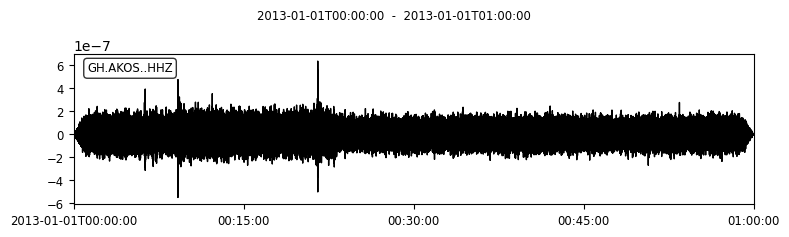

In [15]:
from obspy import read

# Define the path to the mseed file
mseed_file_path = "/content/Mseeds/AKOS_day0_hour0.mseed"

# Read the mseed file
try:
    st_mseed = read(mseed_file_path)

    # Plot the data
    print(f"Plotting data from: {mseed_file_path}")
    st_mseed.plot()

except FileNotFoundError:
    print(f"Error: The file '{mseed_file_path}' was not found.")
except Exception as e:
    print(f"An error occurred while reading or plotting the file: {e}")

Reading 48 mseed files from /content/Mseeds...
Plotting combined data...


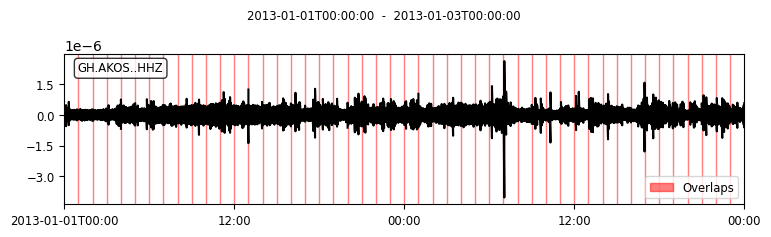

In [16]:
import glob
from obspy import read
import os

# Define the directory containing the mseed files
mseed_directory = "/content/Mseeds"

# Find all .mseed files in the directory
mseed_files = glob.glob(os.path.join(mseed_directory, "*.mseed"))

# Check if any files were found
if not mseed_files:
    print(f"No .mseed files found in {mseed_directory}")
else:
    # Create an empty Stream to hold all the data
    combined_stream = Stream()

    # Read each mseed file and append its content to the combined stream
    print(f"Reading {len(mseed_files)} mseed files from {mseed_directory}...")
    for mseed_file in mseed_files:
        try:
            st = read(mseed_file)
            combined_stream += st
        except Exception as e:
            print(f"Error reading file {mseed_file}: {e}")

    # Plot the combined stream in one window
    if len(combined_stream) > 0:
        print("Plotting combined data...")
        combined_stream.plot()
    else:
        print("No data to plot after attempting to read files.")

Loaded 48 samples from /content/AutoCorr_Outputs, shape per sample: (60, 60, 100)
 Using dummy labels with shape (48, 10, 100) for training demonstration.
zzzzzzzzz[[[0.14383435 0.9761971  0.7433984  ... 0.23641847 0.46556234 0.25915855]
  [0.86036277 0.27560323 0.5407619  ... 0.72605145 0.36316606 0.89875364]
  [0.8787349  0.51891184 0.03182336 ... 0.42340106 0.52750415 0.27679014]
  ...
  [0.24111176 0.9191717  0.46134713 ... 0.29918492 0.9176839  0.13179743]
  [0.40794393 0.61845785 0.94244176 ... 0.22767958 0.38085574 0.20166154]
  [0.68205285 0.12182548 0.3189788  ... 0.21452832 0.45913592 0.16925822]]

 [[0.5021524  0.04827449 0.33901346 ... 0.85160094 0.9471669  0.707257  ]
  [0.6359205  0.03639776 0.19403206 ... 0.5491537  0.0612127  0.15973315]
  [0.23545878 0.19120778 0.7575528  ... 0.9742445  0.38761744 0.99677885]
  ...
  [0.04325812 0.47685137 0.88221496 ... 0.80004776 0.12032084 0.9447303 ]
  [0.512477   0.83103716 0.36226907 ... 0.16887692 0.68302053 0.8124442 ]
  [0.979

Model: "SpatioTemporal_Feature_Extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 60, 60, 100)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mamad                           │ (None, None, None,     │             0 │
│ (CustomAutocorrelationLayer)    │ 100)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute_2 (Permute)             │ (None, 100, None,      │             0 │
│                                 │ None)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 100, 60, 60, 1) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 100, 64)        │        19,200 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100, 10)        │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute_3 (Permute)             │ (None, 10, 100)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,850 (77.54 KB)

 Trainable params: 19,658 (76.79 KB)

 Non-trainable params: 192 (768.00 B)


 Starting training...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.2759 - mae: 0.4309  
Epoch 1: val_loss improved from inf to 0.29947, saving model to trained_spatio_temporal_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 156s 8s/step - loss: 0.2720 - mae: 0.4277 - val_loss: 0.2995 - val_mae: 0.4141



 Training complete. Final model saved to trained_spatio_temporal_model.h5


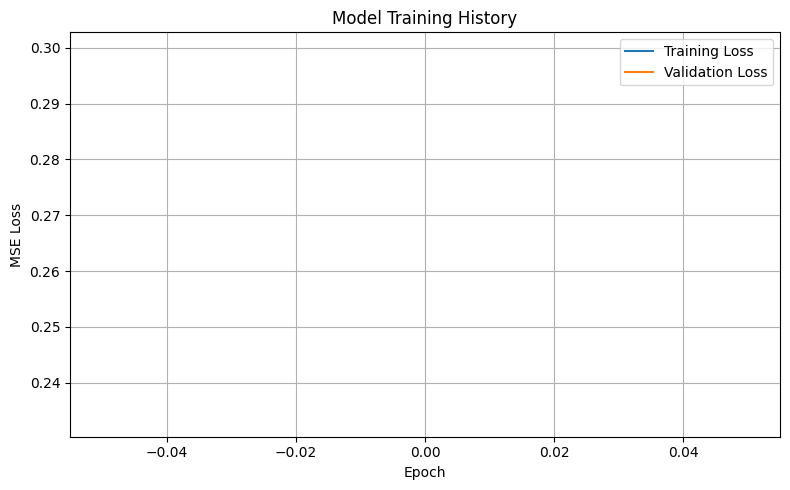

In [11]:
import os
import glob
import numpy as np
import tensorflow as tf
from keras.layers import (
    Input, Permute, Reshape, Conv2D, BatchNormalization,
    ReLU, MaxPooling2D, GlobalAveragePooling2D, TimeDistributed, Dense, Layer
)
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

#  Custom Keras Layer Definition

class CustomAutocorrelationLayer(Layer):
    """
    A custom layer that calculates the temporal auto-correlation of an input tensor.
    It operates on the last axis, which is assumed to be the time dimension.
    The calculation is performed efficiently in the frequency domain using FFT.
    """
    def __init__(self, **kwargs):
        super(CustomAutocorrelationLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # Input shape: (Batch, Height, Width, TimeSteps)
        sequence_length = tf.shape(inputs)[-1]

        # Step 1: Go to Frequency Domain using FFT
        fft_result = tf.signal.rfft(inputs, fft_length=[sequence_length])

        # Step 2: Compute Power Spectral Density (FFT * Conjugate[FFT])
        power_spectral_density = fft_result * tf.math.conj(fft_result)

        # Step 3: Go back to Time Domain using Inverse FFT
        autocorr_result = tf.signal.irfft(power_spectral_density, fft_length=[sequence_length])

        return autocorr_result

    def get_config(self):
        # Required for model saving and loading
        config = super(CustomAutocorrelationLayer, self).get_config()
        return config

#  Spatio-Temporal Model Architecture

def build_spatio_temporal_model(input_shape=(60, 60, 100)):
    """
    Builds the complete Spatio-Temporal feature extraction model.
    """
    inputs = Input(shape=input_shape)

    # --- Part 1: Temporal Transformation & Reshaping ---
    temporal_features = CustomAutocorrelationLayer(name = 'mamad')(inputs)
    permuted = Permute((3, 1, 2))(temporal_features)
    reshaped = Reshape((100, 60, 60, 1))(permuted)

    # --- Part 2: Time-Distributed Spatial Feature Extraction ---
    cnn_block = tf.keras.Sequential([
        Conv2D(32, kernel_size=(3, 3), padding='same'),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), padding='same'),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D(pool_size=(2, 2)),
        GlobalAveragePooling2D()
    ], name='internal_cnn_block')

    time_distributed_cnn = TimeDistributed(cnn_block)(reshaped)

    # --- Part 3: Final Transformation ---
    dense_features = Dense(10, activation='relu')(time_distributed_cnn)
    final_output = Permute((2, 1))(dense_features)

    model = Model(inputs=inputs, outputs=final_output, name='SpatioTemporal_Feature_Extractor')
    return model

#  Data Loading and Preparation

def load_autocorr_data(path="AutoCorr_Outputs", input_shape=(60, 60, 100)):
    """
    Loads all .npy files, reshapes, and normalizes them.
    """
    if not os.path.exists(path):
        print(f"Directory '{path}' not found. Creating dummy data for demonstration.")
        num_samples = 20
        X = np.random.rand(num_samples, *input_shape).astype(np.float32)
        print(f" Created {num_samples} dummy samples with shape {X.shape}")
        return X

    files = sorted(glob.glob(os.path.join(path, "*.npy")))
    if len(files) == 0:
        raise FileNotFoundError(f"No .npy files found in {path}")

    X = []
    for f in files:
        data = np.load(f)
        data = np.nan_to_num(data)
        flat = data.flatten()
        total_needed = np.prod(input_shape)

        if flat.size < total_needed:
            flat = np.pad(flat, (0, total_needed - flat.size))
        elif flat.size > total_needed:
            flat = flat[:total_needed]

        reshaped = flat.reshape(input_shape)
        # Normalize each sample independently
        mean = np.mean(reshaped)
        std = np.std(reshaped)
        reshaped = (reshaped - mean) / (std + 1e-8)
        X.append(reshaped)

    X = np.array(X, dtype=np.float32)
    print(f"Loaded {len(X)} samples from {path}, shape per sample: {X.shape[1:]}")
    return X

# Model Loading Helper

def build_or_load_model(input_shape=(60, 60, 100), model_path="trained_spatio_temporal_model.h5"):
    """
    Loads a previously saved model if it exists, otherwise builds a new one.
    """
    if os.path.exists(model_path):
        print(f" Found existing model at {model_path}, loading...")
        model = tf.keras.models.load_model(
            model_path,
            custom_objects={'CustomAutocorrelationLayer': CustomAutocorrelationLayer},
            compile=False # Do not compile the model during loading
        )
    else:
        print(" Building a new spatio-temporal model...")
        model = build_spatio_temporal_model(input_shape)

    # Always compile the model after loading or building
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    print("--- Model Summary ---")
    model.summary()
    return model

#  Training Pipeline

def train_model():
    """
    Main function to run the data loading, model building, and training process.
    """
    # --- Configuration ---
    INPUT_SHAPE = (60, 60, 100)
    MODEL_PATH = "trained_spatio_temporal_model.h5"
    DATA_PATH = "/content/AutoCorr_Outputs"

    # --- Load Data ---
    X = load_autocorr_data(path=DATA_PATH, input_shape=INPUT_SHAPE)

    # --- Dummy Labels (replace with real targets) ---
    # The model's output shape is (Batch, 10, 100)
    y = np.random.rand(len(X), 10, 100).astype(np.float32)
    print(f" Using dummy labels with shape {y.shape} for training demonstration.")
    print(f'zzzzzzzzz{y}')

    # --- Split Data ---
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # --- Build or Load Model ---
    model = build_or_load_model(INPUT_SHAPE, MODEL_PATH)

    # --- Callbacks ---
    checkpoint = ModelCheckpoint(MODEL_PATH, monitor='val_loss', save_best_only=True, verbose=1)
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # --- Train Model ---
    print("\n Starting training...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=1,
        batch_size=4,
        callbacks=[checkpoint, early_stop],
        verbose=1
    )

    # --- Final Save and Summary ---
    model.save(MODEL_PATH)
    print(f"\n Training complete. Final model saved to {MODEL_PATH}")

    # --- Plot Training History ---
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Model Training History")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return model

# Run the Training Process

if __name__ == '__main__':
    # Note: This script expects .npy files in a directory named "AutoCorr_Outputs".
    # If this directory doesn't exist, it will automatically generate random dummy
    # data to demonstrate the training process.
    trained_model = train_model()

In [12]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, type(layer))

0 input_layer <class 'keras.src.layers.core.input_layer.InputLayer'>
1 mamad <class '__main__.CustomAutocorrelationLayer'>
2 permute <class 'keras.src.layers.reshaping.permute.Permute'>
3 reshape <class 'keras.src.layers.reshaping.reshape.Reshape'>
4 time_distributed <class 'keras.src.layers.rnn.time_distributed.TimeDistributed'>
5 dense <class 'keras.src.layers.core.dense.Dense'>
6 permute_1 <class 'keras.src.layers.reshaping.permute.Permute'>


In [13]:
# Create a new model that outputs the result of the CustomAutocorrelationLayer
# We use the same input layer from the original model and set the output
# to be the output of the custom layer.

# First, find the CustomAutocorrelationLayer in the original model
autocorr_layer = None
for layer in model.layers:
    if isinstance(layer, CustomAutocorrelationLayer):
        autocorr_layer = layer
        break

if autocorr_layer is None:
    print("CustomAutocorrelationLayer not found in the model.")
else:
    # Create a new model with the same input and the custom layer's output
    autocorr_model = Model(inputs=model.input, outputs=model.get_layer(name = 'mamad').output)
    # Display the summary of the new model
    print("--- Autocorrelation Model Summary ---")
    autocorr_model.summary()

    # Load the data
    data_path = "/content/AutoCorr_Outputs"
    input_shape = (60, 60, 100) # Assuming the input shape is still this
    X_data = load_autocorr_data(path=data_path, input_shape=input_shape)

    # Get the output from the autocorrelation layer
    autocorr_output = autocorr_model.predict(X_data)

    # Define the output filename
    output_filename = "/content/autocorr_layer_output.npy"

    # Save the output as a numpy array
    np.save(output_filename, autocorr_output)

    print(f"\nSuccessfully extracted and saved the CustomAutocorrelationLayer output to {output_filename}")

CustomAutocorrelationLayer not found in the model.
